In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.integrate import odeint
#from video_image.formats_conversion import mplib_gif_wrapper
from functools import partial
import torchvision
from torch.utils.data import DataLoader,TensorDataset


$e^{i\pi} +1 = 0$

$$e^x=\sum_{i=0}^\infty \frac{1}{i!}x^i$$

\begin{equation}
  D_{it} =
    \begin{cases}
      1 & \text{if bank $i$ issues ABs at time $t$}\\
      2 & \text{if bank $i$ issues CBs at time $t$}\\
      0 & \text{otherwise}
    \end{cases}  
\end{equation}

# Motivation

## General problem

\begin{equation}
    J:X \times P \rightarrow \Re
\end{equation}
    
\begin{equation}
     G:X \times P \rightarrow X
\end{equation}

Where X and P might be scalars, vectors or time dependent functions

## Specific examples that adhere to this formulation

### Constrained least squares, neural nets as a case of this review

### LQR Controller, co-state

### time dependence optimal control

### Inverse problems

## General derivation vector states

## Derivation for vector states when objective only depends on the last state, Neural nets, discrete odes ....

\begin{array}{lc}
\underset{p}{\mbox{minimize}} & J(x_{T},p)  \\
\end{array}

\begin{array}{lcm}
\mbox{subject to} & g(x,p) = 0 = &   \begin{cases} 
      g(x_{T},x_{T-1},p) = 0  \\
      g(x_{T-1},x_{T-2},p) = 0 \\
      \vdots \\
      g(x_{2},x_{1},p) = 0\\
      g(x_{1},x_{0},p) = 0 \\
      g(x_{0},p) = 0
   \end{cases} \\
\end{array}

\begin{equation}
J_{aug}(x_{T},p) = J(x_{T},p) + \lambda_{T}g(x_{T},x_{T-1},p) + \lambda_{T-1}g(x_{T-1},x_{T-2},p) \ldots \lambda_{1}g(x_{1},x_{0},p)+ \lambda_{0}g(x_{0},p)
\end{equation}

\begin{equation}
d_{p} J_{aug} = \partial_{p} J + \partial_{x}J \partial_{p}x+
\lambda_{T}(\partial_{x_{T}}g_{T}d_{p}x_{T} + \partial_{x_{T-1}}g_{T}d_{p}x_{T-1}+\partial_{p}g_{T})+
\lambda_{T-1}(\partial_{x_{T-1}}g_{T-1}d_{p}x_{T-1} + \partial_{x_{T-2}}g_{T-1}d_{p}x_{T-2}+\partial_{p}g_{T-1})+
\ldots
\lambda_{1}(\partial_{x_{1}}g_{1}d_{p}x_{1} + \partial_{x_{0}}g_{1}d_{p}x_{0}+\partial_{p}g_{1})+
\lambda_{0}(\partial_{x_{0}}g_{0}d_{p}x_{0} + \partial_{p}g_{0})
\end{equation}

\begin{equation}
d_{p} J_{aug} = \partial_{p} J +
(\partial_{x}J+\lambda_{T}\partial_{x_{T}}g_{T})d_{p}x_{T}+
(\lambda_{T}\partial_{x_{T-1}}g_{T}+\lambda_{T-1}\partial_{x_{T-1}}g_{T-1})d_{p}x_{T-1}
\ldots
(\lambda_{1}\partial_{x_{0}}g_{1}+\lambda_{0}\partial_{x_{0}}g_{0})d_{p}x_{0}+
\lambda_{T}\partial_{p}g_{T}+\lambda_{T-1}\partial_{p}g_{T-1}+\ldots +
\lambda_{1}\partial_{p}g_{1}+
\lambda_{0}\partial_{p}g_{0}
\end{equation}

\begin{array}{lm}
\mbox{backward/adjoint system} & \begin{cases}
        \partial_{x}J+\lambda_{T}\partial_{x_{T}}g_{T} = 0 \\
        \lambda_{T}\partial_{x_{T-1}}g_{T}+\lambda_{T-1}\partial_{x_{T-1}}g_{T-1} =0 \\
        \vdots \\
        \lambda_{1}\partial_{x_{0}}g_{1}+\lambda_{0}\partial_{x_{0}}g_{0} = 0 \\
        \end{cases} \\
\end{array}

\begin{array}{lm}
\mbox{Gradient} & \begin{equation}
        d_{p} J_{aug} = \partial_{p} J +
        \lambda_{T}\partial_{p}g_{T}+\lambda_{T-1}\partial_{p}g_{T-1}+\ldots +
        \lambda_{1}\partial_{p}g_{1}+
        \lambda_{0}\partial_{p}g_{0}
        \end{equation}
\end{array}

\begin{array}{lm}
\mbox{forward/state system} &   \begin{cases} 
      g(x_{T},x_{T-1},p) = 0  \\
      g(x_{T-1},x_{T-2},p) = 0 \\
      \vdots \\
      g(x_{2},x_{1},p) = 0\\
      g(x_{1},x_{0},p) = 0 \\
      g(x_{0},p) = 0
   \end{cases} \\
\end{array}

## General derivation time dependent states

\begin{array}{lc}
\underset{p}{\mbox{minimize}} & J(x(t),p) = \int_{0}^{T} f(x(t),p) \,dx  \\
\end{array}

\begin{array}{lc}
\mbox{subject to} & \begin{cases} 
      g(\dot{x},x,p) = 0  \\
      g_{0}(x_{0},p) = 0
   \end{cases} \\
\end{array}

\begin{equation}
 J_{aug} = \int_{0}^{T} f(x(t),p)+ \lambda(t)g(\dot{x},x,p) dt + \mu g_{0}(x_{0},p)
 \end{equation}

\begin{equation}
 d_{p}J_{aug} = \int_{0}^{T} \partial_{p}f+ \partial_{x}f\partial_{p}x  + \lambda(t)(\partial_{\dot{x}}g\underset{\partial_{x}\dot{x}\partial_{p}x=\dot{\partial_{p}x}}{\dot{\partial_{p}x}} +
 \partial_{x}g\partial_{p}x +\partial_{p}g)   dt + 
 \mu (\partial_{x}g_{0}\partial_{p}x + \partial_{p}g_{0})\Bigr|_{t = 0}
 \end{equation}

\begin{equation}
 d_{p}J_{aug} = \int_{0}^{T} \lambda(t)\partial_{\dot{x}}g\dot{\partial_{p}x} = \lambda\partial_{\dot{x}}g\partial_{p}{x}\Bigr|_{t=0}^{t=T}-\int_{0}^{T} \dot{\lambda\partial_{\dot{x}}}g\partial_{p}{x}
 \end{equation}

\begin{equation}
 d_{p}J_{aug} = \int_{0}^{T} \partial_{p}f+ \partial_{x}f\partial_{p}x  + \lambda(t)(\partial_{\dot{x}}g{\dot{\partial_{p}x}} +
 \partial_{x}g\partial_{p}x +\partial_{p}g)   dt + 
 \mu (\partial_{x}g_{0}\partial_{p}x + \partial_{p}g_{0})\Bigr|_{t = 0}
 \end{equation}

\begin{equation}
 d_{p}J_{aug} = \int_{0}^{T} (\partial_{x}f - \dot{\lambda}\partial_{\dot{x}}g-\lambda\dot{\partial_{\dot{x}}}g+\lambda\partial_{x}g)\partial_{p}x
 +\partial_{p}f+\lambda\partial_{p}gdt
 + (\mu\partial_{x}g_{0}-\lambda\partial_{\dot{x}}g)\partial_{p}{x})\Bigr|_{t = 0} +\mu\partial_{p}g_{0}\Bigr|_{t = 0}
 \end{equation}

\begin{array}{lc}
\mbox{forward/state system} & \begin{cases} 
      g(\dot{x},x,p) = 0  \\
      g_{0}(x_{0},p) = 0
   \end{cases} \\
\end{array}

\begin{array}{l}
    t \rightarrow \tau \\
    with \quad t = T-\tau
\end{array}

\begin{array}{lc}
\mbox{backward/adjoint system} & \begin{cases} 
       \dot{\lambda(\tau)}\partial_{\dot{x}}g - \lambda(\tau)\dot{\partial_{\dot{x}}}g + \lambda(\tau)\partial_{x}g = -\partial_{x}f  \\
     \lambda(\tau = 0) = 0 \\
      \mu=\lambda\partial_{\dot{x}}g\partial_{x}g_{0}^{-1}
   \end{cases} \\
\end{array}

\begin{array}{lc}
\mbox{Gradient} & \begin{equation}
 d_{p}J_{aug} = \int_{0}^{T}  \partial_{p}f+\lambda\partial_{p}gdt+\mu\partial_{p}g_{0}\Bigr|_{t = 0}
 \end{equation} \\
\end{array}

## Derivation for fitting  dynamical systems/odenet to data evaluated at discrete times

\begin{equation}
J(x,p) = \int_{0}^{T} \sum_{i}^{{Ndata}}(x_{t_{i}}-\hat{x}(t_{i},p))^{2} \delta(t_{i}) dt
\end{equation}

\begin{equation}
\partial_{x}f = -2\sum_{i}^{{Ndata}}(x_{t_{i}}-\hat{x}(t_{i},p)) \delta(t_{i}) 
\end{equation}

\begin{equation}
 \dot{\lambda}\partial_{\dot{x}}g -\lambda\dot{\partial_{\dot{x}}}g+\lambda\partial_{x}g = - \sum_{i}^{Ndata}A(x_{data},\hat{x})\delta(\tau_{i}) 
\end{equation}

\begin{equation}
\lambda(\tau_{i}^{+})-\lambda(\tau_{i}^{-}) = -A(x_{data},\hat{x}) = 2(x_{t_{i}}-\hat{x}(t_{i},p))
\end{equation}

## Example adjoint fitting linear system to data, analytical and pytorch gradient

\begin{equation}
J(x,p) = (x_{T}-\hat{x}(T,p))^{2}
\end{equation}

\begin{array}{lm}
\mbox{subject to} & \begin{cases}
                    \dot{x} = pAx \\
                    x(t_{0}) = x_{0}
                    \end{cases}
\end{array}

\begin{cases}
\partial_{\dot{x}}g =  \mathbb 1 \\
\dot{\partial_{\dot{x}}g} = 0 \\
\partial_{x}g = -pA \\
\partial_{p}g = -Ax \\
\lambda(\tau = 0) = 2(x_{T}-\hat{x}(T,p)) \\
\mu=\lambda(\tau = T)
\end{cases}

\begin{array}{lm}
\mbox{adjoint system} & \begin{cases}
                        \dot{\lambda^{T}}-\lambda^{T}pA = 0 \\
                        \lambda^{T}(\tau = 0) = 2(x_{T}-\hat{x}(T,p))
                        \end{cases}
\end{array}

\begin{array}{lm}
\mbox{solution forward} & \begin{cases}
                          x = e^{pAt}x_{0}
                          \end{cases}
\end{array}

\begin{array}{lm}
\mbox{solution adjoint} & \begin{cases}
                          \lambda = e^{pA^{T}\tau}\lambda_{0} = e^{pA^{T}\tau}2(x_{T}-\hat{x}(T,p))
                          \end{cases}
\end{array}

\begin{array}{lm}
\mbox{Gradient = $d_{p} J(x,p)$ = } & \begin{cases}
            \int_{\tau = 0}^{\tau = T} (e^{pA^{T}\tau}2(x_{T}-\hat{x}(\tau = 0,p)))(A\hat{x}(\tau))d\tau
                \end{cases}
\end{array}

## Relation to backpropagation draw graph , using pytorch to fit the system

In [ ]:
kgt = -1
gammagt = -0.2


A_ground_truth = np.array([[0.,1.],[kgt,gammagt]])

def system_gt(x,t):
    dxdt = np.dot(A_ground_truth,x)  
    return dxdt

tdata = np.arange(0, 7, 0.1)

x0_ = [2.,2.]

data = odeint(system_gt, x0_, tdata)


xf_gt = data[-1]



plt.plot(data[:,0],data[:,1])

In [ ]:
def _rk4_step(fun, yk, tk, h):
    
    k1 = fun(yk, tk)
    k2 = fun(yk + h/2*k1, tk + h/2)
    k3 = fun(yk + h/2*k2, tk + h/2)
    k4 = fun(yk + h*k3, tk + h)
    
    yk_next = yk + h/6*(k1+2*k2+2*k3+k4)
    
    return yk_next


def rk4(fun, y0, t, retain_grad = False):
        
    y = []
  
    h = t[1]-t[0]
    yk = y0
    y.append(yk)
    
    for i in range(1,len(t)):
        yknext = _rk4_step(fun, yk, t[i-1], h)
        yk = yknext
        
        if retain_grad:
            yk.retain_grad()
            
        y.append(yk)

    return y

def make_system():

    def system_linear(x,t,params):

        k,gamma = params["k"], params["gamma"]

        dx1dt = x[0][1]
        dx2dt = -k*x[0][0]-gamma*x[0][1]

        return torch.cat([dx1dt.view(-1,1), dx2dt.view(-1,1)], dim = 1)



    k = torch.tensor([1]) 
    gamma = torch.nn.Parameter( torch.tensor([0.01]) )



    params = {"k":k,"gamma":gamma}

    system = partial(system_linear, params = params)
    
    return system, params



def forward_pass(x0,T, system):
    
    out = rk4(system, x0, T, retain_grad = True)
    
    return out

def backward_pass(xpred, xdata):
    
    loss = torch.mean( torch.square(xpred-xdata))
    
    loss.backward()
    
    return loss

def make_numpy(out: list):
    
    with torch.no_grad():
    
        out = out.detach().numpy()
    
    return out

def make_grads_numpy(out: list):
    """ picked in inverse order """
    
    with torch.no_grad():
        
        grads = [out[-i-1].grad.numpy() for i in range(len(out))]
        grads = np.concatenate(grads,axis=0)
    
    return grads



def train_loop(T,xdata,indices_data, x0, epochs, register,system, params):
    
    
    
    optim = torch.optim.Adam([params["gamma"]],lr = 0.01)

    xdata = torch.tensor(xdata)
    
    for i in range(epochs):
        optim.zero_grad()

        out = forward_pass(x0, T, system)
        
        xpred = torch.cat([out[i] for i in indices_data], dim = 0)
        
       
        loss = backward_pass(xpred, xdata)
        
        optim.step()

        if i%10==0:
            print("{}  {}".format(i,loss))

        if i%1==0:
            with torch.no_grad():
                
                _out = torch.cat(out, dim = 0)
                
                _out = make_numpy(_out[1:])
                
                _grads = make_grads_numpy(out[1:])
                
                register["outs"].append(_out)
                register["grads"].append(_grads)
    

In [ ]:
indices_data = [-1]

xdata =data[indices_data]

x0 = torch.tensor(x0_).view(1,-1)

T = torch.tensor(tdata)

epochs = 60

register = {"outs": [],
            "grads": []}

system, params = make_system()

train_loop(T, xdata, indices_data ,x0, epochs, register,system, params)

In [ ]:
indices_data = [-1]

xdata =data[indices_data]

xdata = torch.tensor(xdata)

T = torch.tensor(tdata)
x0 = torch.tensor(x0_).view(1,-1)

system, params = make_system()

out = forward_pass(x0,T,system)

xpred = torch.cat([out[i] for i in indices_data], dim = 0)

loss = backward_pass(xpred,xdata)

_out = torch.cat(out, dim = 0)

fwd_pass = make_numpy(_out[1:])

bwd_pass = make_grads_numpy(out[1:])

In [ ]:
def make_figure_fwd_bwd(fwd_pass,bwd_pass, data, indices_data):

    fig = make_subplots( cols = 2, rows = 1, subplot_titles = ("Forward Pass", "Backward Pass"))


    fig.add_trace( go.Scatter( name = "forward pass/state"), row = 1, col = 1)
    fig.add_trace( go.Scatter( name = "backward pass/adjoint state"), row = 1, col = 2)
    fig.add_trace( go.Scatter( x = data[indices_data,0], y = data[indices_data,1], mode = "markers",name = "Data to fit"), row = 1 ,col = 1)
    fig.add_trace( go.Scatter( x = data[:,0], y = data[:,1], mode = "lines", name = "GT trajectory"), row = 1, col = 1)

    axis = dict(range=[-4, 4], autorange=False, zeroline=False)

    layout = go.Layout(
                    width = 1400,
                    height = 800,
                    xaxis = axis,
                    yaxis = axis,
                    xaxis2 = axis,
                    yaxis2 = axis,
                    updatemenus=[dict(type="buttons",
                      buttons=[dict(label="Play",
                                    method="animate",
                                    args=[None])])])

    fig.update_layout(layout)

    N = len(fwd_pass)
    
    frames = []

    for k in np.arange(0,2*N,1):


        x_start, y_start = data[-1,0], data[-1,1]
        x_end, y_end = x_start+bwd_pass[0,0],y_start+bwd_pass[0,1]

        _arrow_dict = dict(
                        x= x_end,
                        y= y_end,
                        xref="x", yref="y",
                        text=r'$-\partial_{x}f = \lambda_{T}$',
                        showarrow=True,
                        axref = "x", ayref="y",
                        ax= x_start,
                        ay= y_start,
                        arrowhead = 3,
                        align="center",
                        arrowcolor='rgb(255,51,0)',)

        arrow1= go.layout.Annotation(dict(
                    _arrow_dict
                    ))

        layout1 = go.Layout(annotations = [arrow1])


        _arrow_dict["xref"] , _arrow_dict["yref"]= "x2", "y2"
        _arrow_dict["axref"] , _arrow_dict["ayref"]= "x2", "y2"

        x_end, y_end = bwd_pass[0,0],bwd_pass[0,1]

        _arrow_dict["x"] ,_arrow_dict["y"] = x_end, y_end
        _arrow_dict["ax"],_arrow_dict["ay"] = 0, 0

        arrow2= go.layout.Annotation(dict(
                    _arrow_dict
                    ))

        layout2 = go.Layout(annotations = [arrow1,arrow2])

        if k<N:

            frame = go.Frame(data=[go.Scatter(name = "forward pass/state",
                x = fwd_pass[:k,0],
                y = fwd_pass[:k,1],
                mode="lines")],
                   )
        elif k>=N:
            frame = go.Frame(data=[go.Scatter(name = "forward pass/state",
                        x = fwd_pass[:N,0],
                        y = fwd_pass[:N,1],
                        mode="lines"),

                          go.Scatter( name = "backward pass/adjoint state",
                            x = bwd_pass[:k-N,0],
                            y = bwd_pass[:k-N,1],
                            mode="lines")],
                            layout = layout2)

        frames.append(frame)



    fig.frames = frames

    return fig

fig = make_figure_fwd_bwd(fwd_pass, bwd_pass, data, indices_data)
fig.show()

gamma

In [ ]:
import plotly.graph_objects as go

import numpy as np




# Create figure
fig = make_subplots(cols = 2, rows = 1)

outs,grads = register["outs"], register["grads"]

N = len(outs)


fig.add_trace(go.Scatter(), row = 1, col = 1)
fig.add_trace(go.Scatter(), row = 1, col = 2)
fig.add_trace(go.Scatter(x = data[1:,0], y = data[1:,1]), row = 1, col = 1)


layout=go.Layout(
    width = 1200,
    height = 800,
    xaxis=dict(range=[-4, 4], autorange=False, zeroline=False),
    yaxis=dict(range=[-4, 4], autorange=False, zeroline=False),
    xaxis2=dict(range=[-4, 4], autorange=False, zeroline=False),
    yaxis2=dict(range=[-4, 4], autorange=False, zeroline=False),
 #   title_text="Training", hovermode="closest",
    updatemenus=[dict(type="buttons",
                      buttons=[dict(label="Play",
                                    method="animate",
                                    args=[None])])])
fig.update_layout(layout)


frames=[go.Frame(
            data=[go.Scatter(
                    x = outs[k][:,0],
                    y = outs[k][:,1],
                    mode="lines"),
                     
                go.Scatter(
                    x = grads[k][:,0],
                    y = grads[k][:,1],
                    mode="lines")])
        
        for k in np.arange(0,N,1)[::1]]

fig.frames = frames


fig.show()

## Resnets as dynamical systems

In [3]:
dataset = torchvision.datasets.FashionMNIST("../DL/data")
dataset_test = torchvision.datasets.FashionMNIST("../DL/data",train = False)

dt_train = TensorDataset(dataset.train_data.view(len(dataset.train_data),1,28,28).float(),dataset.train_labels)
dt_test = TensorDataset(dataset_test.test_data.view(len(dataset_test.test_data),1,28,28).float(),dataset_test.test_labels)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
from torchdiffeq import odeint, odeint_adjoint

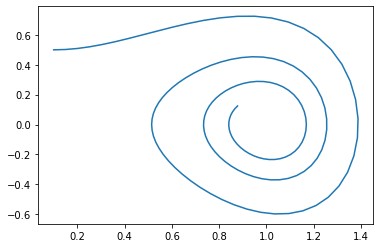

In [156]:
V = lambda x: 0.5 * x**2 * (0.5 * x**2 - 1)
dVdx = lambda x: x**3 - x

xgrid = np.linspace(-1.5, 1.5, 100)
Vgrid = V(xgrid)

#plt.plot(xgrid, Vgrid)
#plt.xlabel('$x$')
#plt.ylabel('$V(x)$')
#plt.figure()
def deriv(X, t, gamma, delta, omega):
    """Return the derivatives dx/dt and d2x/dt2."""

    x, xdot = X
    xdotdot = -dVdx(x) -delta * xdot + gamma * np.cos(omega*t)
    return xdot, xdotdot


system = partial(deriv, gamma = 0, omega = 1.4, delta = 0.2)
from scipy.integrate import odeint as scp_odeint
t = np.arange(0,15,0.1)
x0 = [0.1,0.5]
y = scp_odeint(system,x0,t)
plt.plot(y[:,0],y[:,1])

xdata = y
tdata = t
x0data = x0

In [161]:
class Net(torch.nn.Module):
    def __init__(self,width):
        super().__init__()
        self.layer1 = torch.nn.Linear(width,width)
        self.layer2 = torch.nn.Linear(width,width)
        self.layer3 = torch.nn.Linear(width,width)
    
    def forward(self,t,X):
        
        X = torch.relu(self.layer1(X))
        X = torch.relu(self.layer2(X))
        X = self.layer3(X)
        
        return X

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = Net(10)
        self._linear1 = torch.nn.Linear(1,10)
        self._linear2 = torch.nn.Linear(10,1)
    def forward(self,t,X):
        
        X = self._linear1(X)
        
        X = odeint(self.net,X,t)
        _X = X[-1,:,:].view(-1,10)
        
        
        X = self._linear2(_X)
        
        return X
    
y0 = torch.tensor(x0).float().view(1,-1)
    
t = torch.tensor(tdata).float()

#t = torch.arange(0,10,0.3)
xdata_torch = torch.tensor(xdata).float()


#xdata = torch.arange(0,1,0.01).float().view(-1,1)
#ydata = torch.sin(8*xdata)*xdata**2

In [91]:
torch.mean(torch.square(odeint(net,y0,t)-xdata_torch))

In [143]:
m = Model()

m(t,xdata).shape

torch.Size([150, 100, 10])


torch.Size([150, 1])

In [166]:

m = Net(2)
optim = torch.optim.Adam(m.parameters(),lr = 0.005)

for i in range(500):
    
    optim.zero_grad()
    
    #out = m(t,xdata)
    
    out = odeint(m,y0,t)
    
    _out = out[:,0,:]
    
    loss = torch.mean(torch.square(xdata_torch-_out))
    
    loss.backward()
    
    optim.step()
    
    if i%10 == 0:
        print(i,loss)
    

0 tensor(4.0722, grad_fn=<MeanBackward0>)
10 tensor(3.3152, grad_fn=<MeanBackward0>)
20 tensor(2.7146, grad_fn=<MeanBackward0>)
30 tensor(2.8919, grad_fn=<MeanBackward0>)
40 tensor(2.9576, grad_fn=<MeanBackward0>)
50 tensor(3.0848, grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

In [164]:
with torch.no_grad():
    out = m(t,y0)
    plt.plot(out.numpy()[:,0,0],out.numpy()[:,0,1])
    plt.plot(xdata[:,0],xdata[:,1])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [40]:
loss = torch.sum(out)

In [41]:
loss.backward()

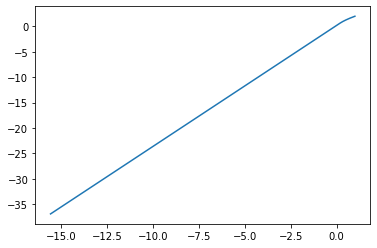

In [37]:
plt.plot(out.detach().numpy()[:,0,0],out.detach().numpy()[:,0,1])

In [12]:
np.shape(out)

torch.Size([50, 1, 2])

# Odenet

In [171]:
def _method_euler(system, x0, T):
    
    xs = [ x0 ]
    
    for i,t in enumerate(T[:-1]):
        
        dt = T[i+1] - t
        
        if i == 0:
            x = system( x0, t)*dt + x0
            
            xs.append(x)
            
        else:
            x = system( x, t)*dt + x
            
            xs.append(x)
    
    return xs

def _rk4_step(fun, yk, tk, h):
    
    k1 = fun(yk, tk)
    k2 = fun(yk + h/2*k1, tk + h/2)
    k3 = fun(yk + h/2*k2, tk + h/2)
    k4 = fun(yk + h*k3, tk + h)
    
    yk_next = yk + h/6*(k1+2*k2+2*k3+k4)
    
    return yk_next




def _method_rk4(fun, y0, t,):
    
    step = t[1]-t[0]
    sep = (t-torch.roll(t,+1))[1:]
    is_regular = ((sep-step) < 1e-4).all()
    
    y = []
    


    h = step
    yk = y0
    y.append(yk)
    for i in range(1,len(t)):
        yknext = _rk4_step(fun, yk, t[i-1], h)
        yk = yknext
        y.append(yk)
        
    
    return y

                       
def odeint_adjoint(fun, x0, T, method = "rk4"):
    
    if method == "euler":
        
        xs = _method_euler(fun, x0, T)
        
    elif method == "rk4":
        
        xs = _method_rk4(fun, x0, T)
    return xs


    
A = torch.nn.Parameter(  torch.tensor(np.array([[0.,1.],[-1.,-0.1]]) ).float())

def system(x,t,params):
    A=params["A"]
    dxdt = torch.matmul(A,x.T)
    return [dxdt[0],dxdt[1]]

params = {"A": A}

def lorenz(x,t, params ):
    '''
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    '''

    x,y,z = x[:,0],x[:,1],x[:,2]
    s,r,b = params["s"],params["r"],params["b"]
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    s_dot = z*y - s*z
    u_dot = z*y - b*x
    return torch.cat([x_dot.view(-1,1),y_dot.view(-1,1),z_dot.view(-1,1),s_dot.view(-1,1),u_dot.view(-1,1)],dim = 1)

    
params = dict(s=torch.nn.Parameter(torch.tensor(9.).float()), r=torch.nn.Parameter(torch.tensor(15.).float()), b=torch.nn.Parameter(torch.tensor(1.367).float()))
    
params = torch.nn.ParameterDict(params)

linear1 = torch.nn.Linear(1,5)
linear2 = torch.nn.Linear(5,1)

def model(x,t):
    x = linear1(x)
    for i in range(len(t)):
        xnext = lorenz(x,t[i],params)*(t[1]-t[0])+x
        x = xnext
    x = linear2(x)
    return x

In [172]:
x = torch.rand((100,3)).view(-1,1).float()
y = torch.sin(8*x)*x**2

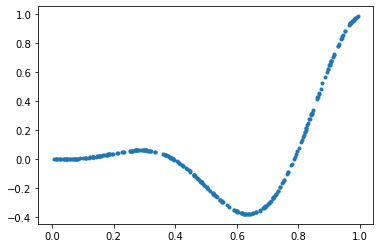

In [173]:
plt.plot(x,y,'.')

In [213]:
optim = torch.optim.Adam(params.values(),lr = 0.5)


t = torch.arange(0,6,0.02).float()

In [214]:
for i in range(500):
    optim.zero_grad()
    
    
    out = model(x,t)
    
    loss = torch.mean( (out-y)**2)
    
    loss.backward()
    
    optim.step()
    
    if i%30 == 0:
        print(loss)

tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.1119, grad_fn=<MeanBackward0>)
tensor(0.0969, grad_fn=<MeanBackward0>)
tensor(0.0965, grad_fn=<MeanBackward0>)
tensor(0.0964, grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

In [142]:
params.values()

odict_values([Parameter containing:
tensor(1.0572, requires_grad=True), Parameter containing:
tensor(16.0283, requires_grad=True), Parameter containing:
tensor(9.3296, requires_grad=True)])

In [215]:
outs = model(x,t)

In [216]:
outs = outs.detach().numpy()

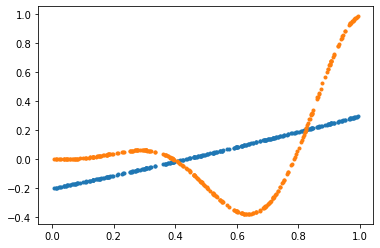

In [217]:
plt.plot(x.numpy()[:,0],outs[:,0],'.')
plt.plot(x.numpy()[:,0],y.numpy()[:,0],'.')